# Predicting S&P 500 returns using Machine Learning models

# Mounting drive

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


# Import the data




In [2]:
# Link to the folder: https://docs.google.com/spreadsheets/d/1IMCtjgX_q9Vr_PnoC2F5-x-it4ZQE3M_McSMejWCpVA/edit?usp=sharing
# The folder is made public.

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from google.colab import auth
import gspread
from google.auth import default
import numpy as np
from scipy import stats

'''
1=GreaterThan1%Drop, 2=NormalDrop, 3=Flat, 4=NormalRise, 5=GreaterThan1%Rise
'''

#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Fetch data into DataFrame
googlesheet = gc.open('HistoricalData').worksheet('Clean')
rows = googlesheet.get_all_values()
data = pd.DataFrame(rows)
data.rename(columns=data.iloc[0], inplace = True)
data.drop(data.index[0], inplace = True)

data = data.drop(['%Change'], axis=1)
data = data.drop(['Sum of % change during consecutive'], axis=1)
data = data.drop(['RS'], axis=1)
data = data.drop(['RSI'], axis=1)
data = data.drop(['Fed Rate'], axis=1)
data = data.drop(['Consecutive Move'], axis=1)

# Display the data
data.head()

,Date,Open,High,Low,Close*,Volume(MM),MACD,MACDsig,Stochastic%K,Stochastic%D,Class
1,"Mar 01, 2010","1,105.36","1,116.11","1,105.36","1,115.71","3,847.64",-3.45,-10.32,99.30,90.38,5
2,"Mar 02, 2010","1,117.01","1,123.46","1,116.51","1,118.31","4,134.68",-1.80,-8.62,91.97,92.36,3
3,"Mar 03, 2010","1,119.36","1,125.64","1,116.58","1,118.79","3,951.32",-0.45,-6.98,89.47,93.58,3
4,"Mar 04, 2010","1,119.12","1,123.73","1,116.66","1,122.97","3,945.01",0.95,-5.40,95.74,92.39,4
5,"Mar 05, 2010","1,125.12","1,139.38","1,125.12","1,138.70","4,133.00",3.28,-3.66,98.87,94.69,5


# Data Analysis & Pre-processing

## Generate a weight attribute using date col.

In [3]:
#Convert 'Date' column from object to datatime dtype.

data['Date'] = pd.to_datetime(data['Date'])

In [4]:
#Extract year from the Date column and store it in a new column named 'Year'

data['Year'] = data['Date'].dt.strftime('%Y')

In [5]:
data['Year'] = data['Year'].astype('int')

In [6]:
data['weights'] = (data['Year'] - data['Year'].min()) / (data['Year'].max() - data['Year'].min())

In [7]:
input_df = data

In [8]:
input_df.head()

,Date,Open,High,Low,Close*,Volume(MM),MACD,MACDsig,Stochastic%K,Stochastic%D,Class,Year,weights
1,2010-03-01,"1,105.36","1,116.11","1,105.36","1,115.71","3,847.64",-3.45,-10.32,99.30,90.38,5,2010,0.0
2,2010-03-02,"1,117.01","1,123.46","1,116.51","1,118.31","4,134.68",-1.80,-8.62,91.97,92.36,3,2010,0.0
3,2010-03-03,"1,119.36","1,125.64","1,116.58","1,118.79","3,951.32",-0.45,-6.98,89.47,93.58,3,2010,0.0
4,2010-03-04,"1,119.12","1,123.73","1,116.66","1,122.97","3,945.01",0.95,-5.40,95.74,92.39,4,2010,0.0
5,2010-03-05,"1,125.12","1,139.38","1,125.12","1,138.70","4,133.00",3.28,-3.66,98.87,94.69,5,2010,0.0


## Pre-process data to remove unwanted characters from the open, close, Vol, High & Low columns

In [9]:
column_names = list(input_df.columns.values)

#Changed some lines to get rid of commas and percentage signs, added 'Fed Rate' at second if-condition.
for j in column_names:
  if j == 'Date':
    continue
  if j == 'Open' or j == 'Low' or j == 'High' or j == 'Close*' or j == 'Volume(MM)':
    #input_df[j] = input_df[j].replace(',','',regex=True)
    input_df[j] = input_df[j].str.replace(',','')
  elif j == 'Sum of % change during consecutive' or j == '%Change' or j == 'Fed Rate':
    #input_df[j] = input_df[j].replace('%','',regex=True).astype('float') / 100.0
    input_df[j] = input_df[j].str.rstrip('%').astype('float') / 100.0
  elif j == 'Stochastic%K':
    input_df[j] = input_df[j].astype('float') / 100.0
  else:
    input_df[j] = input_df[j].astype('float')

# Shift the 'class' column up by one. Replace 'class' with the actual column name or index.
input_df['Class'] = input_df['Class'].shift(-1)

# Drop the last row of the DataFrame
input_df = input_df.iloc[:-1]

In [10]:
input_df.tail()

,Date,Open,High,Low,Close*,Volume(MM),MACD,MACDsig,Stochastic%K,Stochastic%D,Class,Year,weights
3300,2023-04-10,4085.20,4109.50,4072.55,4109.11,3423.65,31.29,12.54,0.8928,87.09,3.0,2023.0,1.0
3301,2023-04-11,4110.29,4124.26,4102.61,4108.94,3665.83,33.53,16.74,0.8920,88.78,2.0,2023.0,1.0
3302,2023-04-12,4121.72,4134.37,4086.94,4091.95,3633.12,33.55,20.10,0.8116,86.55,5.0,2023.0,1.0
3303,2023-04-13,4100.04,4150.26,4099.40,4146.22,3596.59,37.51,23.58,0.9832,89.56,3.0,2023.0,1.0
3304,2023-04-14,4140.11,4163.19,4113.20,4137.64,3575.69,39.50,26.77,0.8994,89.81,4.0,2023.0,1.0


In [11]:
input_df = input_df.astype(float, errors='ignore')

In [12]:
input_df['Date'] = pd.to_datetime(input_df['Date'])


## Add Cboe VIX index to add volatility metric to the dataset

In [13]:
vix_df = pd.read_csv(r'/gdrive/My Drive/VIX_History.csv', parse_dates=True)


In [14]:
vix_df.tail()

,DATE,OPEN,HIGH,LOW,CLOSE
8564,12/18/2023,12.62,12.64,12.40,12.56
8565,12/19/2023,12.60,12.60,12.33,12.53
8566,12/20/2023,12.63,13.93,12.29,13.67
8567,12/21/2023,13.40,14.49,13.34,13.65
8568,12/22/2023,13.72,13.96,13.00,13.03


In [15]:
vix_df.rename(columns={'DATE': 'Date', 'CLOSE': 'Vix_close'}, inplace=True)
vix_df['Date'] = pd.to_datetime(vix_df['Date'])


In [16]:
input_df = vix_df[['Date', 'Vix_close']].merge(input_df, on='Date', how='inner')


In [17]:
input_df.tail()

,Date,Vix_close,Open,High,Low,Close*,Volume(MM),MACD,MACDsig,Stochastic%K,Stochastic%D,Class,Year,weights
3299,2023-04-10,18.97,4085.20,4109.50,4072.55,4109.11,3423.65,31.29,12.54,0.8928,87.09,3.0,2023.0,1.0
3300,2023-04-11,19.10,4110.29,4124.26,4102.61,4108.94,3665.83,33.53,16.74,0.8920,88.78,2.0,2023.0,1.0
3301,2023-04-12,19.09,4121.72,4134.37,4086.94,4091.95,3633.12,33.55,20.10,0.8116,86.55,5.0,2023.0,1.0
3302,2023-04-13,17.80,4100.04,4150.26,4099.40,4146.22,3596.59,37.51,23.58,0.9832,89.56,3.0,2023.0,1.0
3303,2023-04-14,17.07,4140.11,4163.19,4113.20,4137.64,3575.69,39.50,26.77,0.8994,89.81,4.0,2023.0,1.0


## Add commodity prices to the dataset

In [18]:
# prompt: write code to fetch commodity prices from yfinance api in python for the following commodity tickers - BZ, CL, GC, SI, HG, PL

import yfinance as yf
# Fetch commodity prices from yfinance api
commods = yf.download(['BZ=F', 'CL=F', 'GC=F', 'SI=F', 'HG=F', 'PL=F'], start='2010-05-25', end='2023-04-14')['Close']
# Merge the commodity prices with the input_df dataframe
input_df = input_df.merge(commods, on='Date')


[*********************100%%**********************]  6 of 6 completed


In [19]:
commods.head()

,BZ=F,CL=F,GC=F,HG=F,PL=F,SI=F
Date,,,,,,
2010-05-25,69.550003,68.750000,1197.800049,3.0335,1489.900024,17.763000
2010-05-26,71.739998,71.510002,1213.300049,3.0715,1528.300049,18.292000
2010-05-27,74.660004,74.550003,1211.900024,3.1515,1550.900024,18.457001
2010-05-28,74.019997,73.970001,1212.199951,3.0970,1547.400024,18.410999
2010-06-01,72.709999,72.580002,1224.800049,3.0540,1547.400024,18.540001


In [20]:
input_df.head()

,Date,Vix_close,Open,High,Low,Close*,Volume(MM),MACD,MACDsig,Stochastic%K,Stochastic%D,Class,Year,weights,BZ=F,CL=F,GC=F,HG=F,PL=F,SI=F
0,2010-05-25,34.61,1067.42,1074.75,1040.78,1074.03,7329.58,-26.29,-17.44,0.2504,20.76,2.0,2010.0,0.0,69.550003,68.750000,1197.800049,3.0335,1489.900024,17.763000
1,2010-05-26,35.02,1075.51,1090.75,1065.59,1067.95,4521.05,-27.87,-19.53,0.2046,20.10,5.0,2010.0,0.0,71.739998,71.510002,1213.300049,3.0715,1528.300049,18.292000
2,2010-05-27,29.68,1074.27,1103.52,1074.27,1103.06,5698.46,-26.00,-20.82,0.4690,30.80,1.0,2010.0,0.0,74.660004,74.550003,1211.900024,3.1515,1550.900024,18.457001
3,2010-05-28,32.07,1102.59,1102.59,1084.78,1089.41,4871.21,-25.32,-21.72,0.3662,34.66,1.0,2010.0,0.0,74.019997,73.970001,1212.199951,3.0970,1547.400024,18.410999
4,2010-06-01,35.54,1087.30,1094.77,1069.89,1070.71,5271.48,-25.99,-22.57,0.2254,35.35,5.0,2010.0,0.0,72.709999,72.580002,1224.800049,3.0540,1547.400024,18.540001


## Divide data into pre-pandemic, pandemic, and post-pandemic datasets

In [21]:
pre_pandemic = input_df[input_df['Date'] <= '2020-02-29']
during_pandemic = input_df[(input_df['Date'] >= '2020-03-01') & (input_df['Date'] <= '2021-05-31')]
post_pandemic = input_df[input_df['Date'] >= '2021-06-01']


In [22]:
pre_pandemic.head()

,Date,Vix_close,Open,High,Low,Close*,Volume(MM),MACD,MACDsig,Stochastic%K,Stochastic%D,Class,Year,weights,BZ=F,CL=F,GC=F,HG=F,PL=F,SI=F
0,2010-05-25,34.61,1067.42,1074.75,1040.78,1074.03,7329.58,-26.29,-17.44,0.2504,20.76,2.0,2010.0,0.0,69.550003,68.750000,1197.800049,3.0335,1489.900024,17.763000
1,2010-05-26,35.02,1075.51,1090.75,1065.59,1067.95,4521.05,-27.87,-19.53,0.2046,20.10,5.0,2010.0,0.0,71.739998,71.510002,1213.300049,3.0715,1528.300049,18.292000
2,2010-05-27,29.68,1074.27,1103.52,1074.27,1103.06,5698.46,-26.00,-20.82,0.4690,30.80,1.0,2010.0,0.0,74.660004,74.550003,1211.900024,3.1515,1550.900024,18.457001
3,2010-05-28,32.07,1102.59,1102.59,1084.78,1089.41,4871.21,-25.32,-21.72,0.3662,34.66,1.0,2010.0,0.0,74.019997,73.970001,1212.199951,3.0970,1547.400024,18.410999
4,2010-06-01,35.54,1087.30,1094.77,1069.89,1070.71,5271.48,-25.99,-22.57,0.2254,35.35,5.0,2010.0,0.0,72.709999,72.580002,1224.800049,3.0540,1547.400024,18.540001


## Visualize trends in daily Open, Close Price, and %change

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def visualize_trend(df, col):
  plt.figure(figsize=(10,5))
  plt.plot(df['Date'], df[col])
  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  plt.title('Daily Close Prices Over Time')
  plt.xlabel('Year')
  plt.ylabel('Close Price')
  plt.grid(True)
  plt.show()


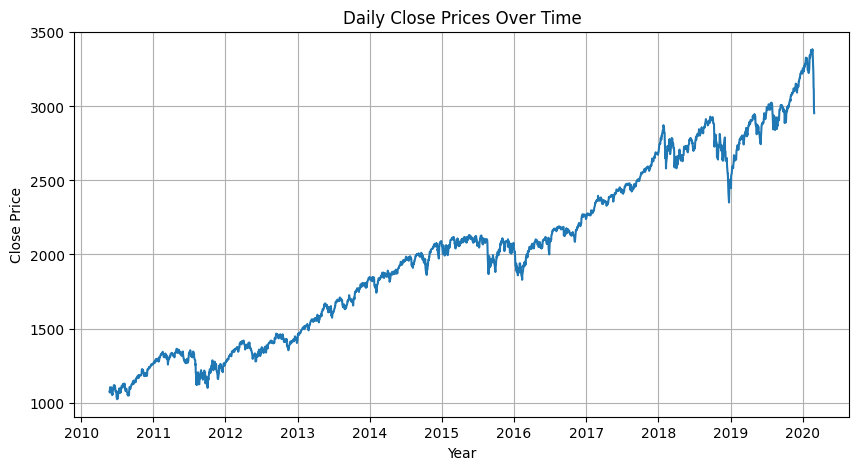

In [24]:
visualize_trend(pre_pandemic, 'Close*')


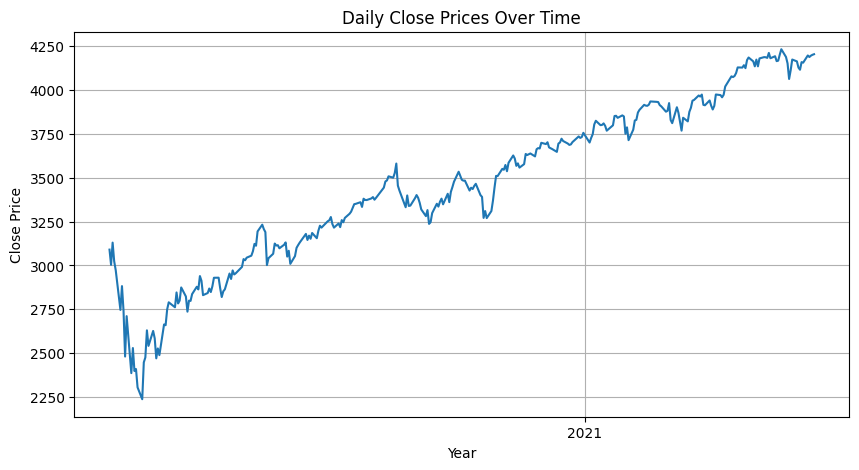

In [25]:
visualize_trend(during_pandemic, 'Close*')


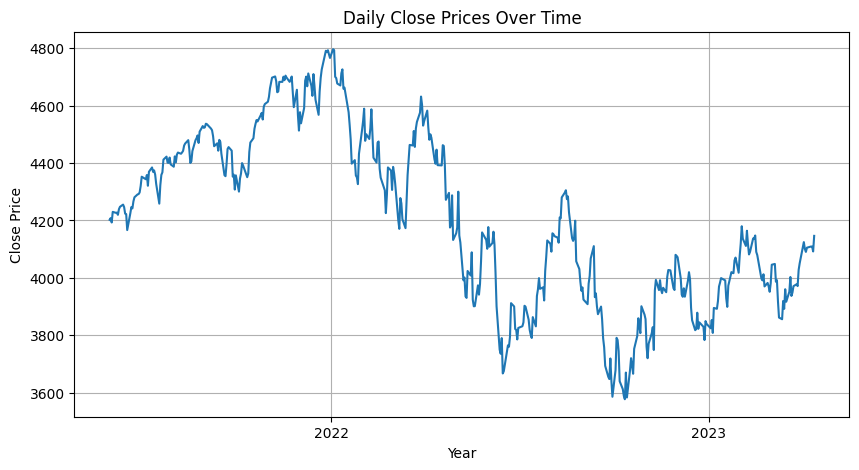

In [26]:
visualize_trend(post_pandemic, 'Close*')


## Class distribution in the dataset

In [27]:
pre_label_df = pre_pandemic['Class']
during_label_df = during_pandemic['Class']
post_label_df = post_pandemic['Class']

In [28]:
pre_label_df.value_counts()

3.0    958
4.0    582
2.0    412
5.0    271
1.0    233
Name: Class, dtype: int64

In [29]:
post_label_df.value_counts()

3.0    120
5.0     92
1.0     88
2.0     86
4.0     84
Name: Class, dtype: int64

In [30]:
during_label_df.value_counts()

5.0    78
3.0    69
4.0    67
2.0    53
1.0    48
Name: Class, dtype: int64

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_class_dist(labels):
  plt.figure(figsize=(8,6))
  plt.hist(labels.sort_values(), color='blue', alpha=0.7, rwidth = 1)
  plt.title('Distribution of classes in the dataset')
  plt.xlabel('Class')
  plt.ylabel('Frequency')
  plt.grid(axis='y', alpha=0.75)
  plt.show()

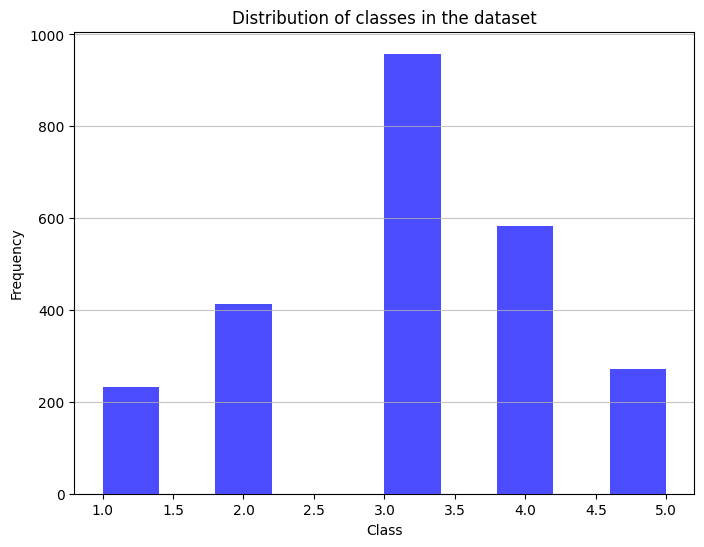

In [32]:
visualize_class_dist(pre_label_df)


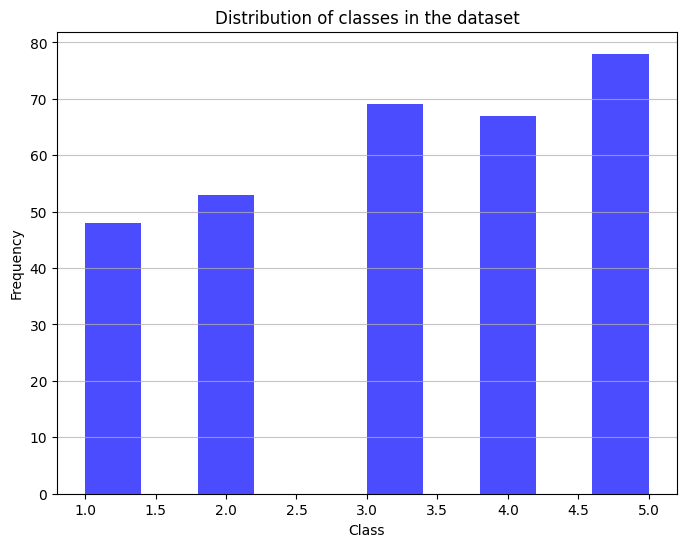

In [33]:
visualize_class_dist(during_label_df)


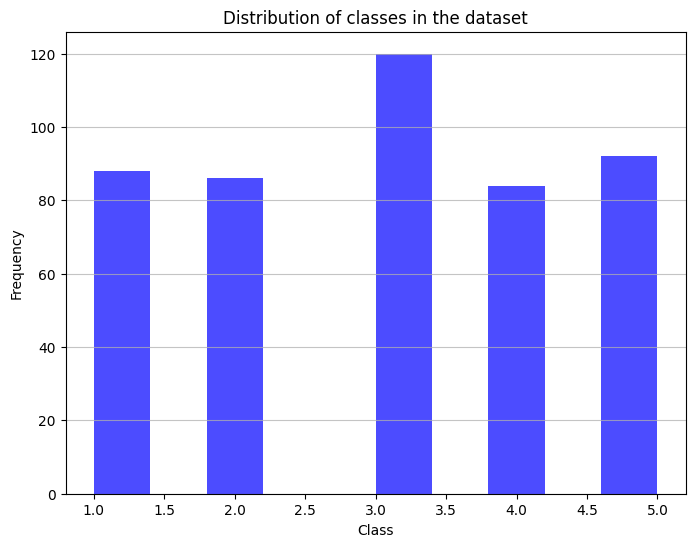

In [34]:
visualize_class_dist(post_label_df)


## Examine Correlation among the attributes in the dataset

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_corr(df):
  temp = df.copy()
  temp = temp.drop(['Year', 'weights'], axis=1)
  # Calculate correlation matrix
  corr = temp.corr()

  # Create a heatmap
  plt.figure(figsize=(10,8))
  sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
  plt.title("Correlation Matrix")
  plt.show()

<ipython-input-35-cd8899cd7c98>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = temp.corr()


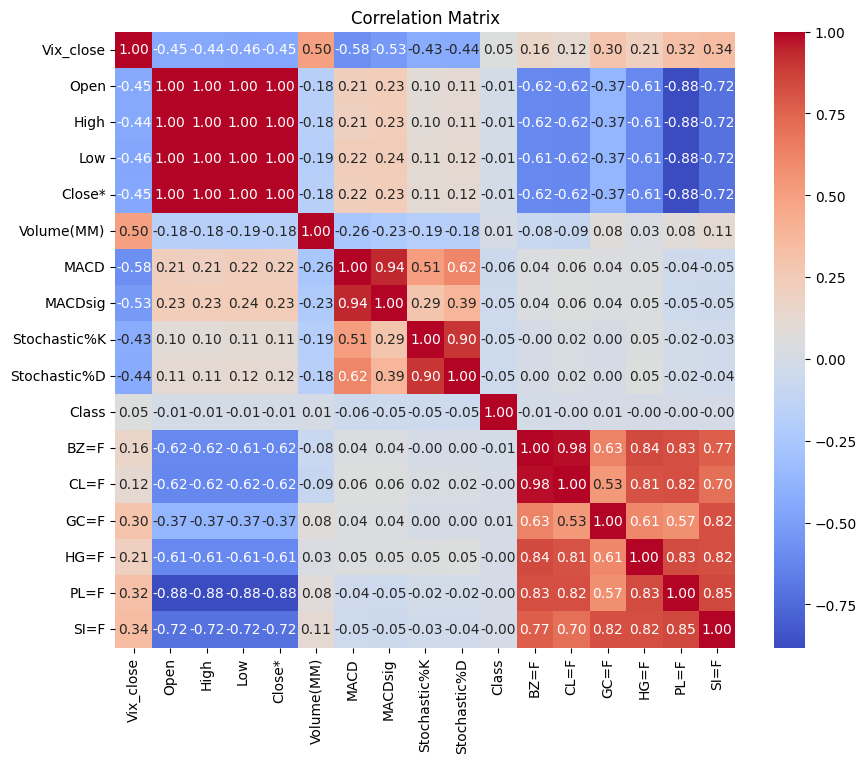

In [36]:
plot_corr(pre_pandemic)

<ipython-input-35-cd8899cd7c98>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = temp.corr()


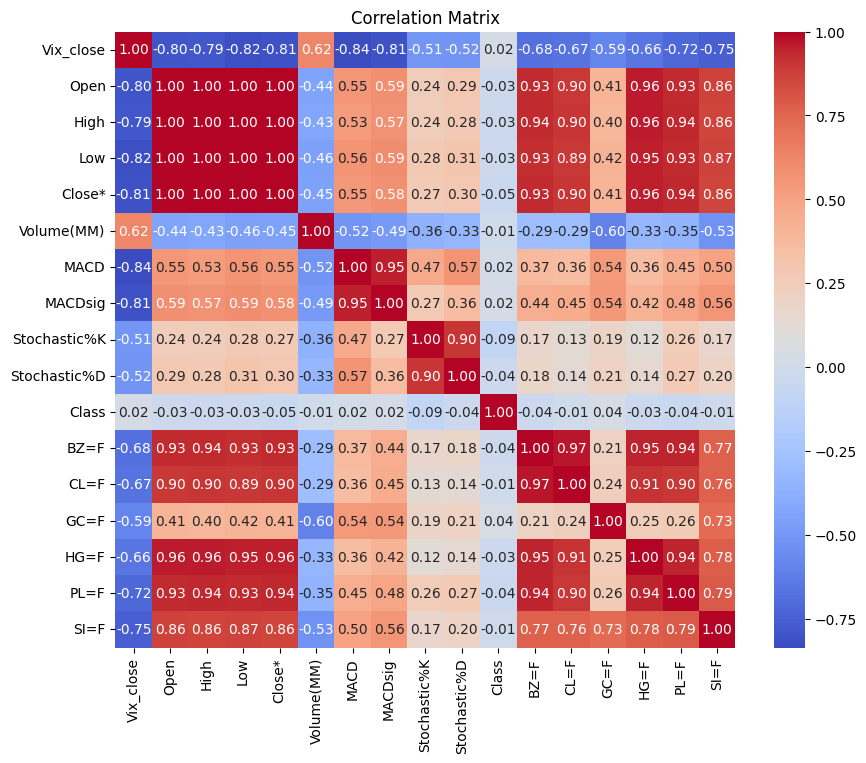

In [37]:
plot_corr(during_pandemic)

<ipython-input-35-cd8899cd7c98>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = temp.corr()


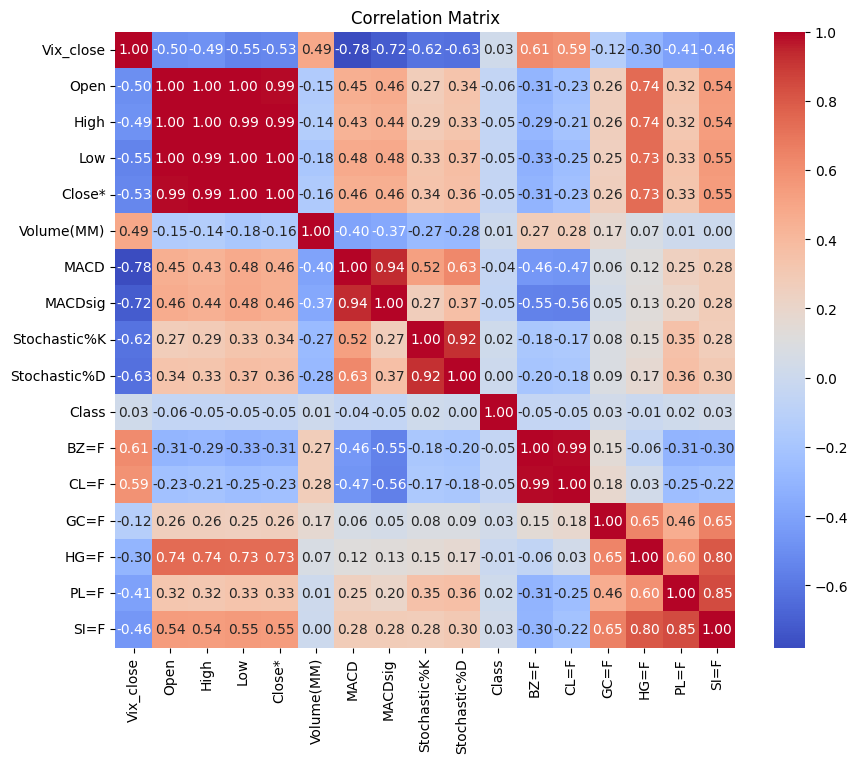

In [39]:
plot_corr(post_pandemic)

Inference:

There is high correlation among few of the column pairs which are need to be tackled to decrease chances of overfitting and high colinearity among attributes:

1. MACD,Stochastic%D  is dropped since it has a very strong +ve correlation with MACDSignal
2. PL=F, SI=F, and BZ=F are dropped too due to high corr among the other commodities and the open, high, low, and close prices of S&P 500 index.

In [ ]:
pre_pandemic = pre_pandemic.drop(['MACD', 'MACDsig', 'Stochastic%K', 'Stochastic%D', 'PL=F', 'SI=F', 'BZ=F'], axis=1)
during_pandemic = during_pandemic.drop(['MACD', 'Stochastic%D', 'MACDsig', 'Stochastic%K', 'PL=F', 'SI=F', 'BZ=F'], axis=1)
post_pandemic = post_pandemic.drop(['MACD', 'Stochastic%D', 'MACDsig', 'Stochastic%K', 'PL=F', 'SI=F', 'BZ=F'], axis=1)


In [43]:
pre_pandemic = pre_pandemic.drop(['MACDsig', 'Stochastic%K'], axis=1)
during_pandemic = during_pandemic.drop(['MACDsig', 'Stochastic%K'], axis=1)
post_pandemic = post_pandemic.drop(['MACDsig', 'Stochastic%K'], axis=1)


<ipython-input-35-cd8899cd7c98>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = temp.corr()


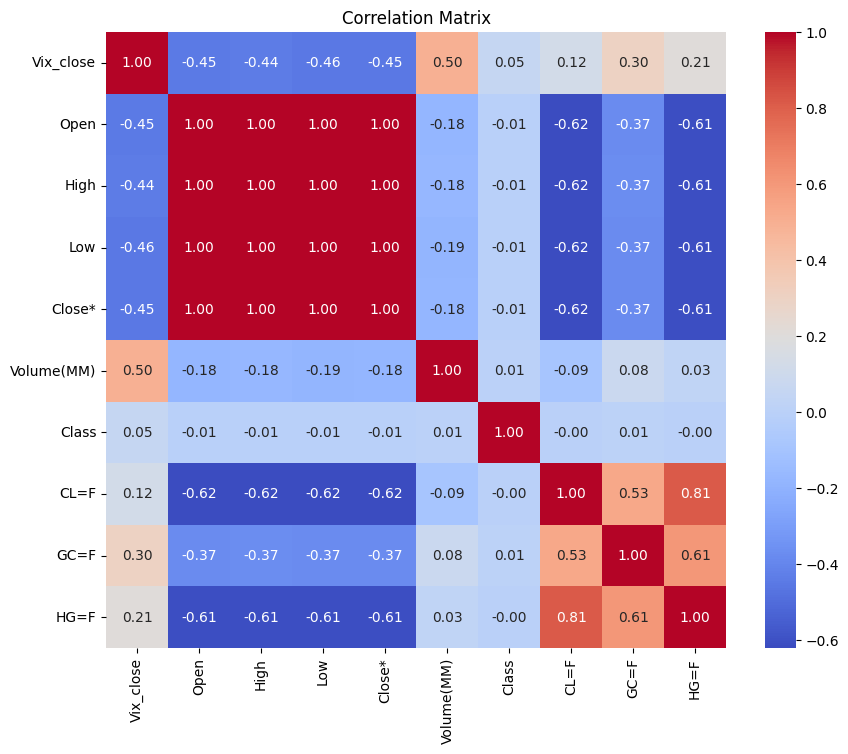

In [45]:
plot_corr(pre_pandemic)

## Examine volatility in the 3 periods of the market

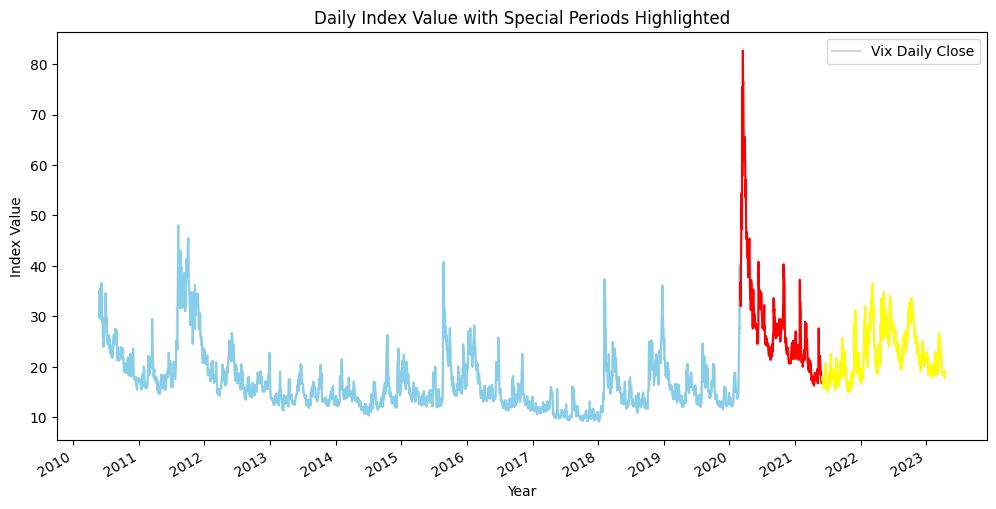

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'df' is your DataFrame and it has 'date' and 'index_value' columns
# Convert date column to datetime if it's not already
input_df['Date'] = pd.to_datetime(input_df['Date'])

# Define your special date ranges (start and end dates)
special_ranges = [
    {'start': '2010-05-25', 'end': '2020-02-29'},  {'start': '2020-03-01', 'end': '2021-05-31'}, {'start': '2021-06-01', 'end': '2023-04-13	'}

]

colors = ['skyblue', 'red', 'yellow']

# Start plotting
plt.figure(figsize=(12, 6))

# Plot the entire dataset
plt.plot(input_df['Date'], input_df['Vix_close'], label='Vix Daily Close', color='lightgray')

# Highlight specific date ranges
for date_range, color in zip(special_ranges, colors):
    # Extracting the part of the dataframe within the date range
    mask = (input_df['Date'] >= date_range['start']) & (input_df['Date'] <= date_range['end'])
    plt.plot(input_df['Date'][mask], input_df['Vix_close'][mask], color=color)

# Improve the x-axis with only the year shown
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotation

plt.title('Daily Index Value with Special Periods Highlighted')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.show()


## Examine if any strong skewness exists in the input attributes

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_skewness(df):
  # Assuming 'during_pandemic' is your DataFrame and is already defined
  skewness = df.drop(columns=['weights', 'Year', 'Class']).skew()
  print(skewness)
  # Creating the bar plot
  plt.figure(figsize=(10,6))  # This sets the figure size for better readability
  plt.bar(skewness.index, skewness.values, color='skyblue')  # Plotting the bar chart
  plt.title('Skewness of Columns in during_pandemic DataFrame')
  plt.xlabel('Columns')
  plt.ylabel('Skewness')
  plt.xticks(rotation=45)  # Rotating the x labels for better readability if needed
  plt.show()


<ipython-input-47-b21c37fc090b>:6: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = df.drop(columns=['weights', 'Year', 'Class']).skew()


Vix_close     1.809777
Open          0.214043
High          0.216419
Low           0.211412
Close*        0.213551
Volume(MM)    0.836546
CL=F          0.096696
GC=F          0.848488
HG=F          0.405344
dtype: float64


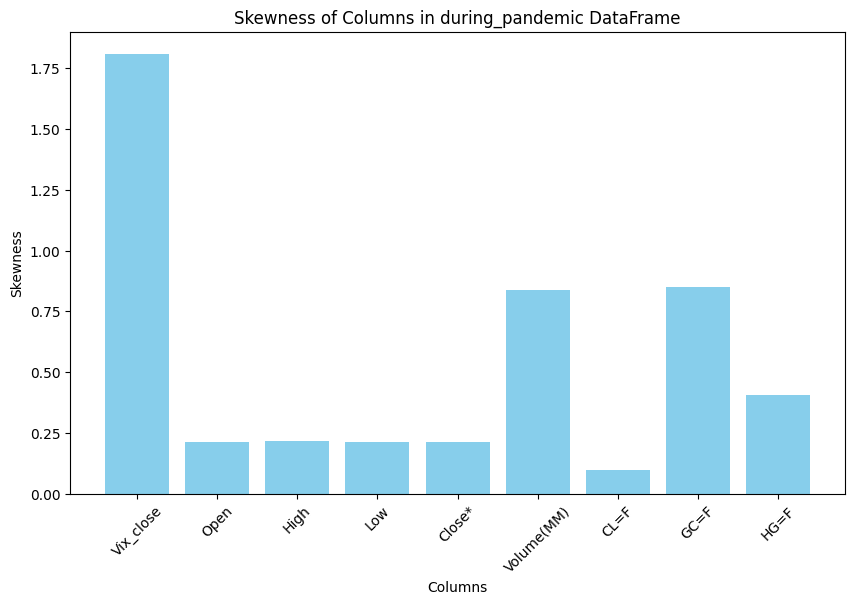

In [48]:
df = pre_pandemic
plot_skewness(df)

<ipython-input-47-b21c37fc090b>:6: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = df.drop(columns=['weights', 'Year', 'Class']).skew()


Vix_close     2.330048
Open         -0.266919
High         -0.228565
Low          -0.306822
Close*       -0.268621
Volume(MM)    1.233831
CL=F         -0.692843
GC=F         -0.427403
HG=F          0.425030
dtype: float64


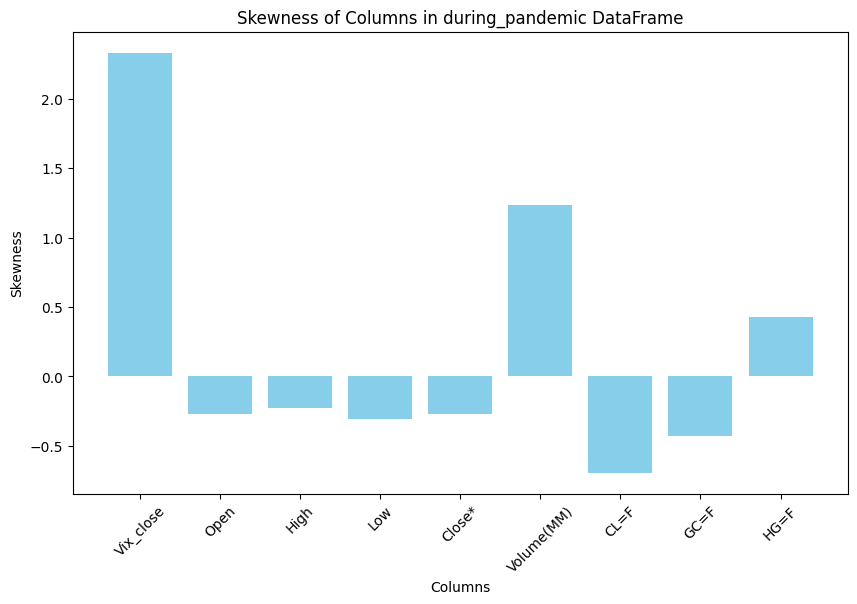

In [49]:
df = during_pandemic
plot_skewness(df)

<ipython-input-47-b21c37fc090b>:6: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = df.drop(columns=['weights', 'Year', 'Class']).skew()


Vix_close     0.560235
Open          0.030386
High          0.039221
Low           0.027523
Close*        0.024482
Volume(MM)    1.724133
CL=F          0.804002
GC=F          0.191839
HG=F         -0.486802
dtype: float64


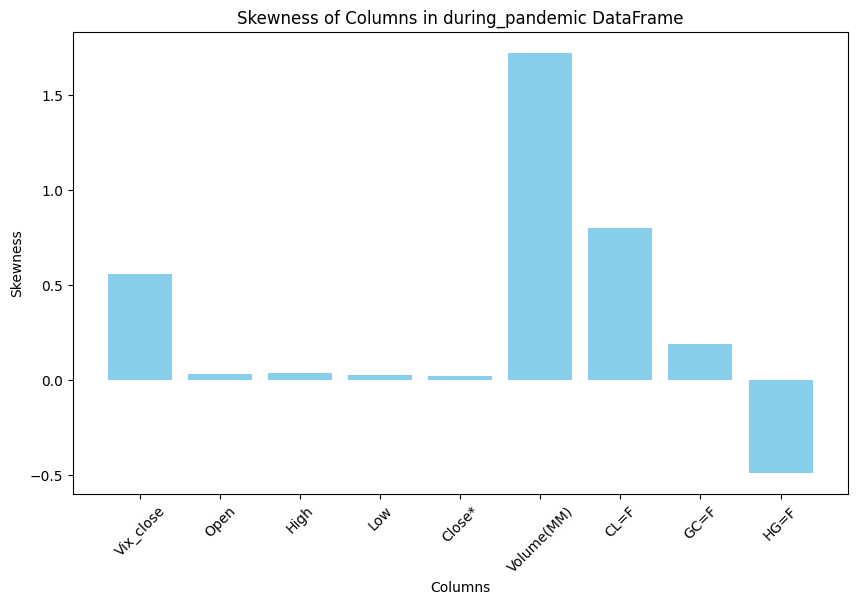

In [50]:
df = post_pandemic
plot_skewness(df)

### In the pre-pandemic period following were observed in various attributes:

1. There is significant skewness in indicators like Vix close, MACDSignal, and Stochastic%K and hence rwequires handling.

2. Both Volume and gold close prices have moderate skewness but still require handling. However, open, close, high, and low prices of the S&P 500 donot show significant deviation from normal distribution and same goes for other commodity prices except gold.

3. Gold commodities are usually affected rapidly during any events of uncertainity and therefore can show more positice skewness as compared to other commodities as it is often considered a safe haven by investors.  

In [51]:
#Handling skewness in the pre_pandemic dataset:

# Handling GC=F with positive skewness using log transformation:

cols_to_transform = ['GC=F']
pre_pandemic[cols_to_transform] = pre_pandemic[cols_to_transform].apply(np.log)


In [52]:
for col in ['Vix_close', 'Volume(MM)']:
    pre_pandemic[col], _ = stats.boxcox(pre_pandemic[col])

## Using 95% Historical VaR metric to model risk in the dataset  

In [54]:
pre_pandemic['log_return'] = np.log(pre_pandemic['Close*'] / pre_pandemic['Close*'].shift(1))

rolling_window = 60
confidence_level = 0.05
# Calculate rolling VaR
pre_pandemic['VaR_95'] = pre_pandemic['log_return'].rolling(window=rolling_window).quantile(confidence_level)

pre_pandemic = pre_pandemic.dropna(subset=['VaR_95'])

pre_pandemic = pre_pandemic.drop('log_return', axis=1)


## Generate dataset for varying lookback days

In [55]:
df_one = pre_pandemic.copy()


In [56]:
df_one.head()

,Date,Vix_close,Open,High,Low,Close*,Volume(MM),Class,Year,weights,CL=F,GC=F,HG=F,VaR_95
60,2010-08-19,0.929278,1092.44,1092.44,1070.66,1075.63,106.777341,2.0,2010.0,0.0,74.430000,7.117854,3.3175,-0.028616
61,2010-08-20,0.928042,1075.63,1075.63,1063.91,1071.69,100.237557,2.0,2010.0,0.0,73.459999,7.112490,3.2910,-0.028616
62,2010-08-23,0.928270,1073.36,1081.58,1067.08,1067.36,92.889202,1.0,2010.0,0.0,73.099998,7.112246,3.2915,-0.028616
63,2010-08-24,0.930508,1063.20,1063.20,1046.68,1051.87,108.503672,4.0,2010.0,0.0,71.629997,7.116232,3.2395,-0.028616
64,2010-08-25,0.929601,1048.98,1059.38,1039.83,1055.33,107.605892,2.0,2010.0,0.0,72.519997,7.122463,3.2110,-0.028616


In [57]:
def assign_class(percentage_change):
    if percentage_change <= -1.0:
        return 1
    elif -1.0 < percentage_change <= -0.3:
        return 2
    elif -0.3 < percentage_change < 0.3:
        return 3
    elif 0.3 <= percentage_change < 1.0:
        return 4
    else:
        return 5

def calc_return(org_df, period):
  temp = org_df.copy()

  temp['five_day_return'] = temp['Close*'].pct_change(periods=period) * 100
  temp = temp.dropna()
  temp = temp.copy()

  temp['Class'] = temp['five_day_return'].apply(assign_class)
  temp = temp.drop('five_day_return', axis=1)

  temp.head()

  return temp

df_five = calc_return(df_one, 4)
df_ten = calc_return(df_one, 9)
df_twenty = calc_return(df_one, 19)


In [58]:
label_one = df_one.pop('Class')
label_five = df_five.pop('Class')
label_ten = df_ten.pop('Class')
label_twenty = df_twenty.pop('Class')

In [59]:
df_one = df_one.drop(['Date', 'Year'], axis=1)
df_five = df_five.drop(['Date', 'Year'], axis=1)
df_ten = df_ten.drop(['Date', 'Year'], axis=1)
df_twenty = df_twenty.drop(['Date', 'Year'], axis=1)

# Split dataset into train and test set and Normalize

In [60]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def split_data(df, label_df):
  df = df.dropna()
  label_df = label_df.dropna()
  num_rows = df.shape[0]
  last_20_percent = int(num_rows * 0.2)
  X_train = df[:num_rows-last_20_percent+1]
  X_test = df[-last_20_percent:]
  y_train = label_df[:num_rows-last_20_percent+1]
  y_test = label_df[-last_20_percent:]
  weights = df['weights']
  weights_train = weights[:num_rows-last_20_percent+1]
  weights_test = weights[-last_20_percent:]

  train_scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = train_scaler.transform(X_train)

  test_scaler = preprocessing.StandardScaler().fit(X_test)
  X_test = test_scaler.transform(X_test)



  return X_train, X_test, y_train, y_test, weights_train, weights_test


In [61]:
X_train_one, X_test_one, y_train_one, y_test_one, weights_train_one, weights_test_one = split_data(df_one, label_one)
X_train_five, X_test_five, y_train_five, y_test_five, weights_train_five, weights_test_five = split_data(df_five, label_five)
X_train_ten, X_test_ten, y_train_ten, y_test_ten, weights_train_ten, weights_test_ten = split_data(df_ten, label_ten)
X_train_twenty, X_test_twenty, y_train_twenty, y_test_twenty, weights_train_twenty, weights_test_twenty = split_data(df_twenty, label_twenty)


In [62]:
unique_values, counts = np.unique(y_test_one, return_counts=True)

# Training & Backtesting model on the datasets

## SVM Classifier

In [81]:
#Importing necessary libraries

import numpy as np
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [66]:
def plot_learning_curve(classifier, X, y):
  '''The following function is used to plot the learning curve for both training and cross-validation accuracy
  for differnt number of training examples to find if the model is under-fitting or over-fitting'''

  plt.figure()
  plt.style.use(['ggplot'])
  plt.title("Learning curve")
  train_sizes, train_acc, test_acc = learning_curve(
        classifier, X, y, n_jobs=-1, shuffle = True, train_sizes=np.linspace(.1, 1.0, 10))

  train_acc_mean = np.mean(train_acc, axis=1)
  train_acc_std = np.std(train_acc, axis=1)
  test_acc_mean = np.mean(test_acc, axis=1)
  test_acc_std = np.std(test_acc, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_acc_mean - train_acc_std,
                     train_acc_mean + train_acc_std, alpha=0.1,
                     color="r")
  plt.fill_between(train_sizes, test_acc_mean - test_acc_std,
                     test_acc_mean + test_acc_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_acc_mean, 'o-', color="r",
             label="Training accuracy")
  plt.plot(train_sizes, test_acc_mean, 'o-', color="g",
             label="Cross-validation accuracy")

  plt.legend(loc="best")
  plt.show()

In [67]:
parameters = [

            {
              "kernel": ["rbf", "poly", "linear"],
              "C": [0.1, 0.5, 1, 5],
              "gamma": [0.01, 0.05, 0.1]
            }
        ]

class_names = [1, 2, 3, 4, 5]

In [68]:
def svm_classifier(X_train, X_test, y_train, y_test, parameters, sample_weight_train, sample_weight_test):
  '''The following function when called will perform an exhaustive search
      over all the parameters to find the set of parameters which give
      the best fit of parameters with lowest cross validation error'''
  svm = SVC(probability = True, class_weight='balanced')

  print("finding best value for C and gamma")
  print("################")

  #Finding best parameters C and gamma using GridsearchCV

  clf = GridSearchCV(svm, param_grid = parameters,  cv=5, n_jobs=-1, verbose=2, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel(), sample_weight = sample_weight_train)
  ypred = clf.predict(X_test)

  titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

  plt.show()
  tuned_clf = clf.best_estimator_
  print("###################")
  print()
  y_pred_test = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred_test, sample_weight=sample_weight_test)  # Pass sample_weight as a list
  print("Accuracy is", acc)
  print("###################")
  print()
  print(classification_report(y_test, ypred, zero_division=1, sample_weight = sample_weight_test))
  return tuned_clf, ypred, acc

## Backtesting classifier for varying lookback days

In [499]:
def backtest(Xtrain, ytrain, Xtest, ytest, parameters, weights_train, weights_test):
  weights_train = weights_train.tolist()
  weights_test = weights_test.tolist()

  svm_tuned_clf, svm_ypred, acc = svm_classifier(Xtrain, Xtest, ytrain, ytest, parameters, weights_train, weights_test)
  return svm_tuned_clf

finding best value for C and gamma
################
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Confusion matrix, without normalization
[[  3  34   0   0   0]
 [  3  53   0   0   0]
 [  8 120   0   0   0]
 [  7  84   0   0   0]
 [  1  37   0   0   0]]
Normalized confusion matrix
[[0.08108108 0.91891892 0.         0.         0.        ]
 [0.05357143 0.94642857 0.         0.         0.        ]
 [0.0625     0.9375     0.         0.         0.        ]
 [0.07692308 0.92307692 0.         0.         0.        ]
 [0.02631579 0.97368421 0.         0.         0.        ]]


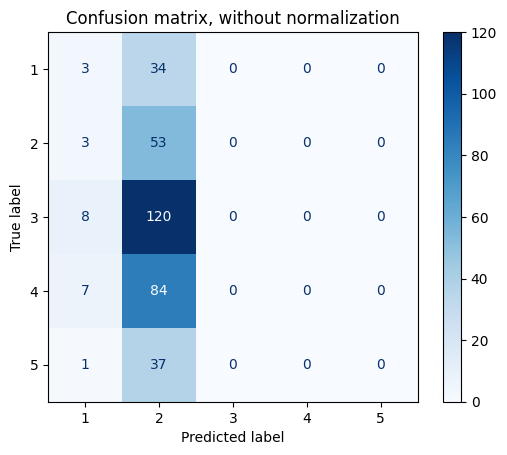

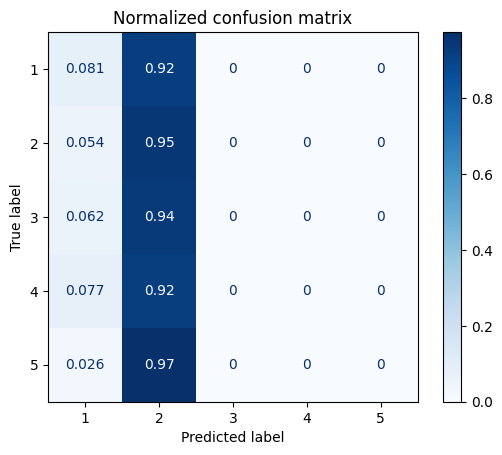

###################

Accuracy is 0.1607958251793868
###################

              precision    recall  f1-score   support

         1.0       0.14      0.08      0.10        37
         2.0       0.16      0.95      0.28        56
         3.0       1.00      0.00      0.00       128
         4.0       1.00      0.00      0.00        91
         5.0       1.00      0.00      0.00        38

    accuracy                           0.16       350
   macro avg       0.66      0.21      0.08       350
weighted avg       0.77      0.16      0.05       350



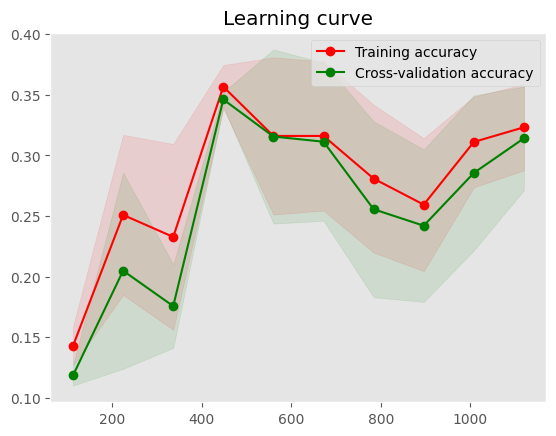

In [500]:
svm_tuned_clf = backtest(X_train_one, y_train_one, X_test_one, y_test_one, parameters, weights_train_one, weights_test_one)
plot_learning_curve(svm_tuned_clf, X_train_one, y_train_one)

finding best value for C and gamma
################
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Confusion matrix, without normalization
[[49 14  1  0  0]
 [ 8 19 12  1  0]
 [ 4 15 16 16 13]
 [ 2  8 23 34 27]
 [ 1  2  2 49 33]]
Normalized confusion matrix
[[0.765625   0.21875    0.015625   0.         0.        ]
 [0.2        0.475      0.3        0.025      0.        ]
 [0.0625     0.234375   0.25       0.25       0.203125  ]
 [0.0212766  0.08510638 0.24468085 0.36170213 0.28723404]
 [0.01149425 0.02298851 0.02298851 0.56321839 0.37931034]]


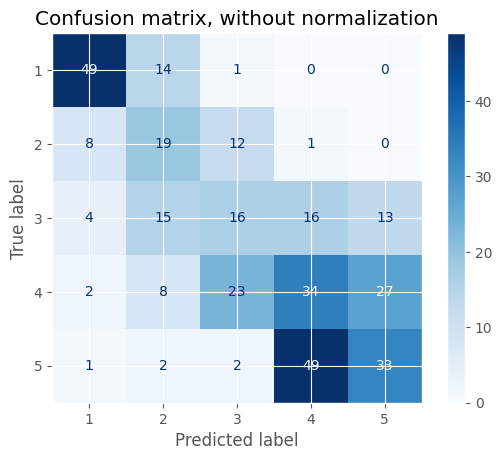

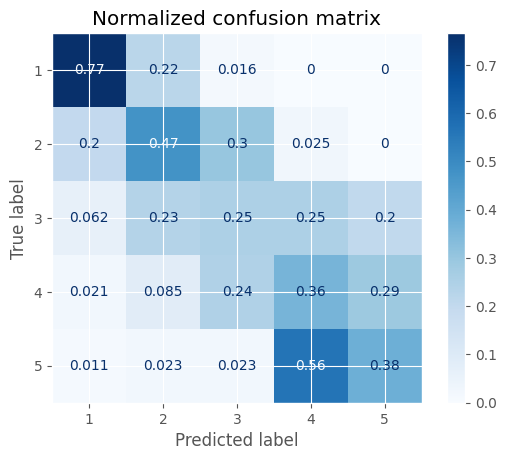

###################

Accuracy is 0.4336167429692609
###################

              precision    recall  f1-score   support

           1       0.77      0.77      0.77        64
           2       0.33      0.47      0.39        40
           3       0.30      0.25      0.27        64
           4       0.34      0.36      0.35        94
           5       0.45      0.38      0.41        87

    accuracy                           0.43       349
   macro avg       0.44      0.45      0.44       349
weighted avg       0.44      0.43      0.43       349



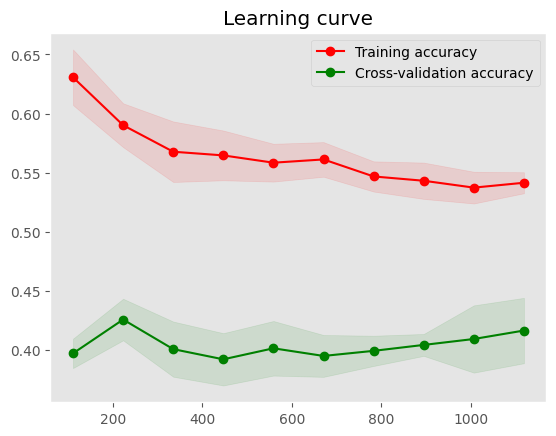

In [501]:
svm_tuned_clf = backtest(X_train_five, y_train_five, X_test_five, y_test_five, parameters, weights_train_five, weights_test_five)
plot_learning_curve(svm_tuned_clf, X_train_five, y_train_five)

finding best value for C and gamma
################
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Confusion matrix, without normalization
[[ 47   4   0   0   0]
 [ 12  10   5   1   1]
 [  2  13   9  11   2]
 [  0   6  16  20  17]
 [  5   5   5  36 122]]
Normalized confusion matrix
[[0.92156863 0.07843137 0.         0.         0.        ]
 [0.4137931  0.34482759 0.17241379 0.03448276 0.03448276]
 [0.05405405 0.35135135 0.24324324 0.2972973  0.05405405]
 [0.         0.10169492 0.27118644 0.33898305 0.28813559]
 [0.02890173 0.02890173 0.02890173 0.20809249 0.70520231]]


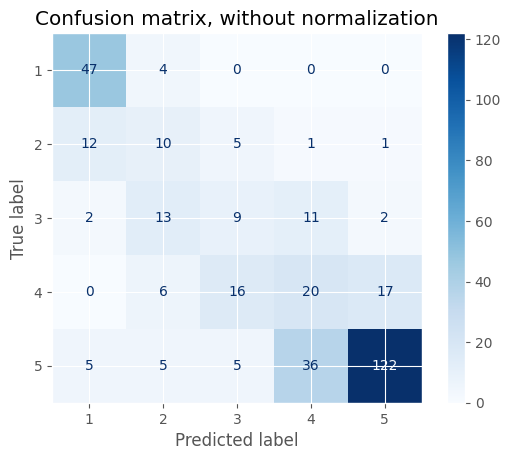

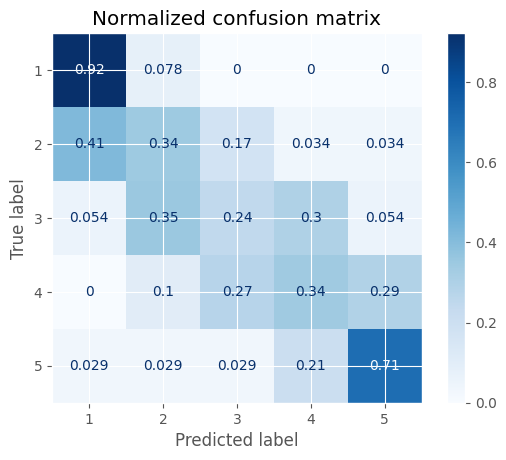

###################

Accuracy is 0.6026814911706998
###################

              precision    recall  f1-score   support

           1       0.71      0.92      0.80        51
           2       0.26      0.34      0.30        29
           3       0.26      0.24      0.25        37
           4       0.29      0.34      0.31        59
           5       0.86      0.71      0.77       173

    accuracy                           0.60       349
   macro avg       0.48      0.51      0.49       349
weighted avg       0.63      0.60      0.61       349



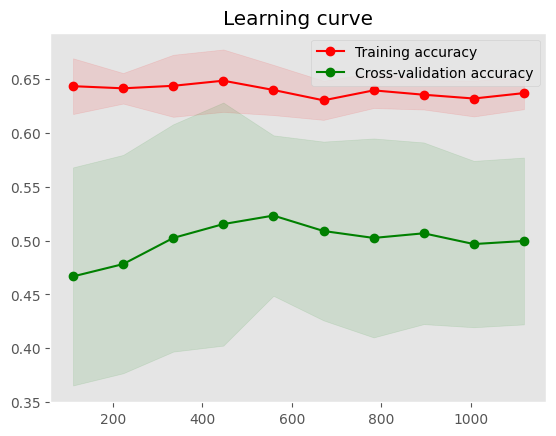

In [502]:
svm_tuned_clf = backtest(X_train_ten, y_train_ten, X_test_ten, y_test_ten, parameters, weights_train_ten, weights_test_ten)
plot_learning_curve(svm_tuned_clf, X_train_ten, y_train_ten)

finding best value for C and gamma
################
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Confusion matrix, without normalization
[[ 30   0   0   0   0]
 [  7   2   0   1   0]
 [  8   5   4   3   0]
 [  3   4   5  16   0]
 [ 12  13  16  46 174]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.        ]
 [0.7        0.2        0.         0.1        0.        ]
 [0.4        0.25       0.2        0.15       0.        ]
 [0.10714286 0.14285714 0.17857143 0.57142857 0.        ]
 [0.04597701 0.04980843 0.06130268 0.17624521 0.66666667]]


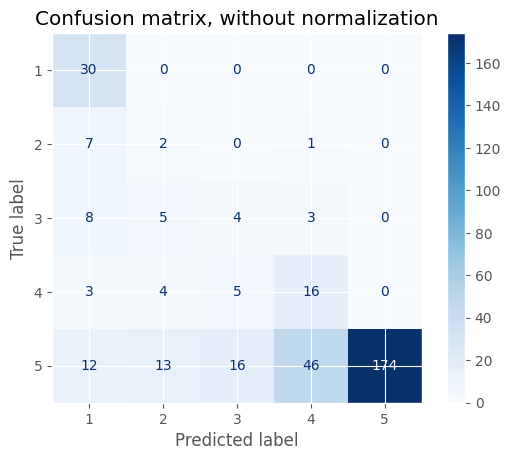

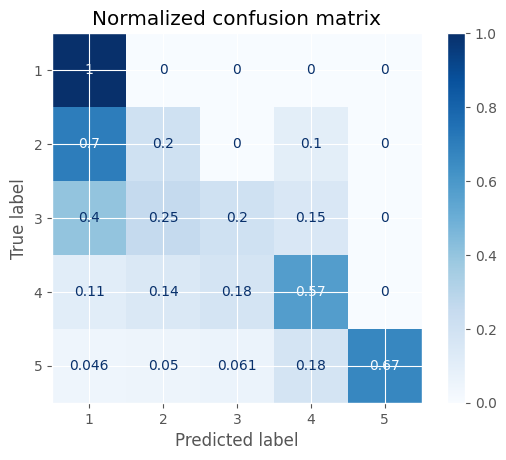

###################

Accuracy is 0.6569653368214519
###################

              precision    recall  f1-score   support

           1       0.50      1.00      0.67        30
           2       0.08      0.20      0.12        10
           3       0.16      0.20      0.18        20
           4       0.24      0.57      0.34        28
           5       1.00      0.67      0.80       261

    accuracy                           0.65       349
   macro avg       0.40      0.53      0.42       349
weighted avg       0.82      0.65      0.70       349



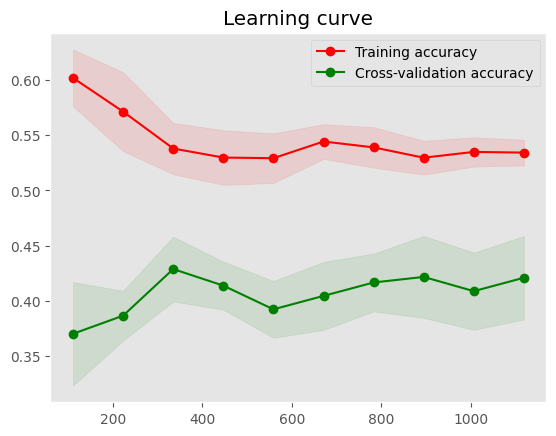

In [503]:
svm_tuned_cl = backtest(X_train_twenty, y_train_twenty, X_test_twenty, y_test_twenty, parameters, weights_train_twenty, weights_test_twenty)
plot_learning_curve(svm_tuned_clf, X_train_five, y_train_five)

### Random Forest Classifier

In [69]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 40, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]

parameters = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

In [70]:
def Random_forest_clf(X_train, X_test, y_train, y_test, parameters, sample_weight_train, sample_weight_test):
  '''The following function uses random forest classifier and GridsearchCV to find
     the best fit for the parameters and plot confusion matrix for the test '''

  rfc = RandomForestClassifier()
  clf = GridSearchCV(rfc, param_grid = parameters,  cv=3, n_jobs=-1, verbose=2, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel(), sample_weight = sample_weight_train)
  y_pred = clf.predict(X_test)
  y_predprob = clf.predict_proba(X_test)

  titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

  tuned_clf = clf.best_estimator_
  disp.ax_.set_title('Confusion matrix')
  print("###################")
  print()
  acc = accuracy_score(y_test, y_pred, sample_weight=sample_weight_test)  # Pass sample_weight as a list
  print("Accuracy is", acc)
  print("###################")
  print()
  print(classification_report(y_test, y_pred, zero_division = 1, sample_weight = sample_weight_test))
  return tuned_clf, y_pred, acc

In [71]:
def backtest_rfc(Xtrain, ytrain, Xtest, ytest, parameters, weights_train, weights_test):
  weights_train = weights_train.tolist()
  weights_test = weights_test.tolist()

  rfc_tuned_clf, rfc_ypred, acc = Random_forest_clf(Xtrain, Xtest, ytrain, ytest, parameters, weights_train, weights_test)
  return rfc_tuned_clf

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Confusion matrix, without normalization
[[  1   2  13   8  17]
 [  0   0  55  16  13]
 [  0   2 130  30  20]
 [  1   1  81  23  22]
 [  0   1   6  11  26]]
Normalized confusion matrix
[[0.02439024 0.04878049 0.31707317 0.19512195 0.41463415]
 [0.         0.         0.6547619  0.19047619 0.1547619 ]
 [0.         0.01098901 0.71428571 0.16483516 0.10989011]
 [0.0078125  0.0078125  0.6328125  0.1796875  0.171875  ]
 [0.         0.02272727 0.13636364 0.25       0.59090909]]
###################

Accuracy is 0.37680115273775205
###################

              precision    recall  f1-score   support

         1.0       0.50      0.03      0.05 27.307692307692314
         2.0       0.00      0.00      0.00 55.84615384615388
         3.0       0.46      0.71      0.56 121.69230769230785
         4.0       0.26      0.18      0.21 86.07692307692322
         5.0       0.27      0.59      0.37 29.384615384615394

    accuracy       

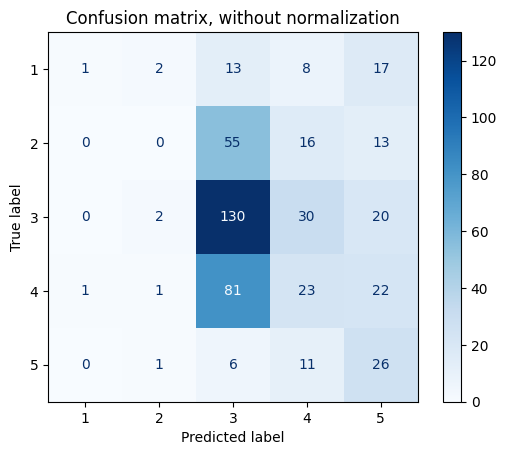

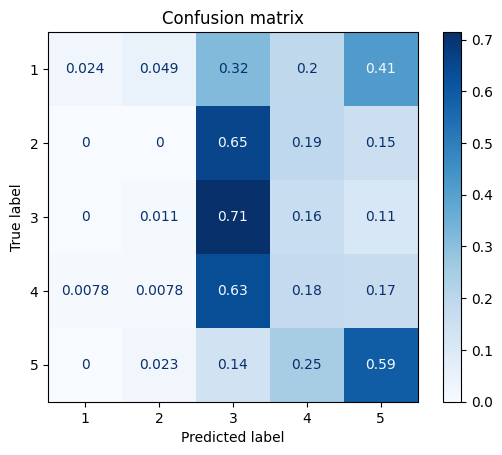

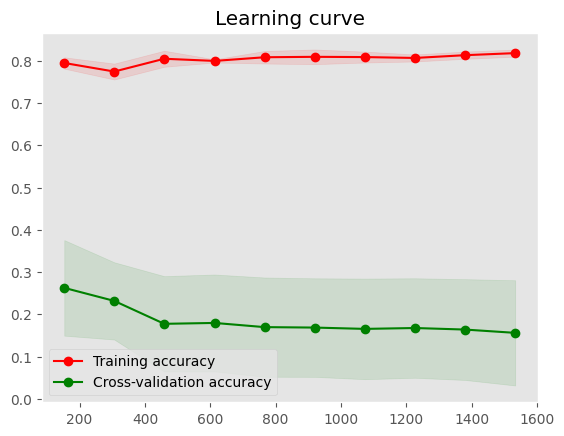

In [73]:
rfc_tuned_clf = backtest_rfc(X_train_one, y_train_one, X_test_one, y_test_one, parameters, weights_train_one, weights_test_one)
plot_learning_curve(rfc_tuned_clf, X_train_one, y_train_one)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Confusion matrix, without normalization
[[75  9  0  3 11]
 [10  8  3  9 16]
 [ 8 12  6 20 29]
 [16  5 13 35 47]
 [28 11 14 29 61]]
Normalized confusion matrix
[[0.76530612 0.09183673 0.         0.03061224 0.1122449 ]
 [0.2173913  0.17391304 0.06521739 0.19565217 0.34782609]
 [0.10666667 0.16       0.08       0.26666667 0.38666667]
 [0.13793103 0.04310345 0.11206897 0.30172414 0.40517241]
 [0.1958042  0.07692308 0.0979021  0.2027972  0.42657343]]
###################

Accuracy is 0.3873917228103946
###################

              precision    recall  f1-score   support

           1       0.55      0.77      0.64 64.76923076923082
           2       0.18      0.17      0.17 30.538461538461547
           3       0.17      0.08      0.11 50.153846153846175
           4       0.37      0.30      0.33 78.0769230769232
           5       0.37      0.43      0.40 96.15384615384632

    accuracy                           0.39 319

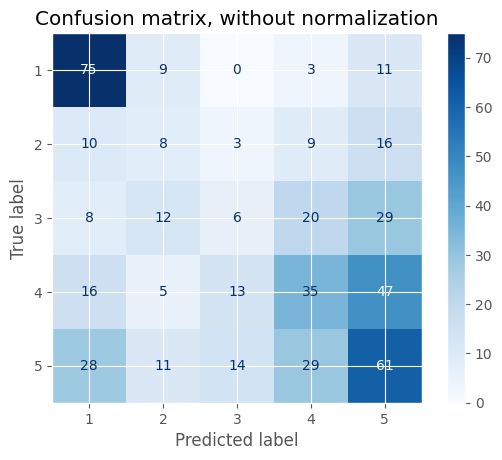

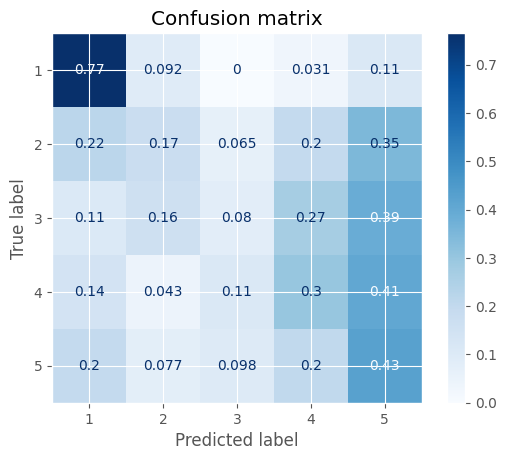

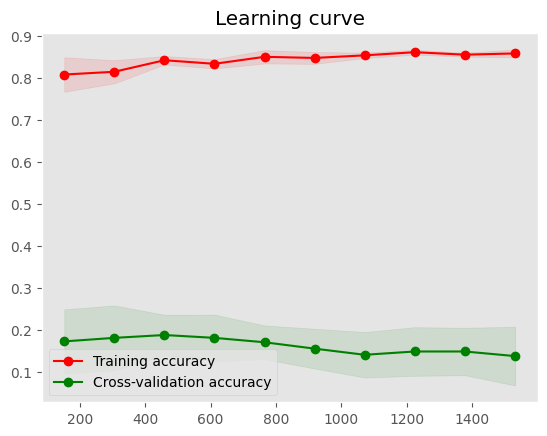

In [74]:
rfc_tuned_clf = backtest_rfc(X_train_five, y_train_five, X_test_five, y_test_five, parameters, weights_train_five, weights_test_five)
plot_learning_curve(rfc_tuned_clf, X_train_five, y_train_five)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Confusion matrix, without normalization
[[ 93   0   0   0  11]
 [  9   4   0   4  15]
 [ 15   1   1   3  29]
 [ 10   2   2  10  44]
 [ 34   5   8  29 148]]
Normalized confusion matrix
[[0.89423077 0.         0.         0.         0.10576923]
 [0.28125    0.125      0.         0.125      0.46875   ]
 [0.30612245 0.02040816 0.02040816 0.06122449 0.59183673]
 [0.14705882 0.02941176 0.02941176 0.14705882 0.64705882]
 [0.15178571 0.02232143 0.03571429 0.12946429 0.66071429]]
###################

Accuracy is 0.5378495660559305
###################

              precision    recall  f1-score   support

           1       0.57      0.90      0.70 68.46153846153855
           2       0.34      0.13      0.19 21.307692307692307
           3       0.09      0.02      0.03 32.076923076923094
           4       0.22      0.15      0.18 45.61538461538463
           5       0.61      0.66      0.63 151.61538461538464

    accuracy        

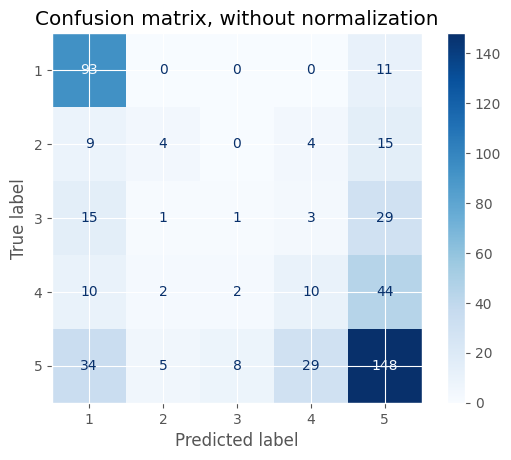

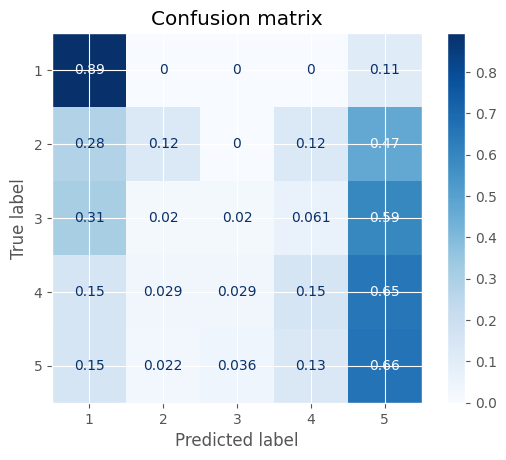

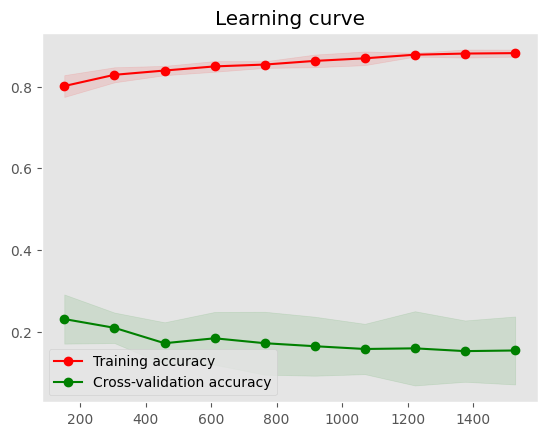

In [75]:
rfc_tuned_clf = backtest_rfc(X_train_ten, y_train_ten, X_test_ten, y_test_ten, parameters, weights_train_ten, weights_test_ten)
plot_learning_curve(rfc_tuned_clf, X_train_ten, y_train_ten)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Confusion matrix, without normalization
[[ 97   0   0   0  10]
 [ 11   0   0   0   8]
 [ 13   0   0   0  11]
 [  4   0   0   0  29]
 [ 41   0   0   0 251]]
Normalized confusion matrix
[[0.90654206 0.         0.         0.         0.09345794]
 [0.57894737 0.         0.         0.         0.42105263]
 [0.54166667 0.         0.         0.         0.45833333]
 [0.12121212 0.         0.         0.         0.87878788]
 [0.14041096 0.         0.         0.         0.85958904]]
###################

Accuracy is 0.7354791868344628
###################

              precision    recall  f1-score   support

           1       0.58      0.91      0.71 70.38461538461549
           2       1.00      0.00      0.00 12.692307692307692
           3       1.00      0.00      0.00 15.846153846153841
           4       1.00      0.00      0.00 21.23076923076923
           5       0.82      0.86      0.84 197.69230769230703

    accuracy        

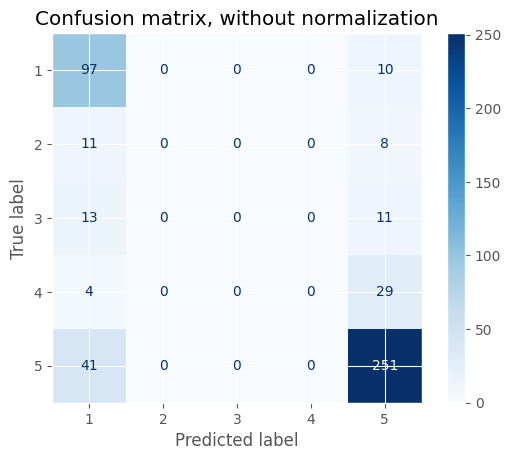

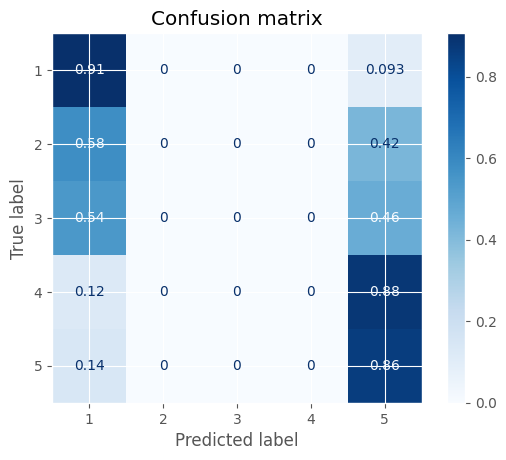

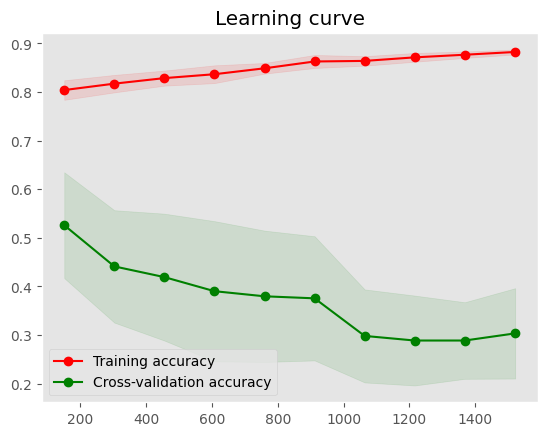

In [76]:
rfc_tuned_clf = backtest_rfc(X_train_twenty, y_train_twenty, X_test_twenty, y_test_twenty, parameters, weights_train_twenty, weights_test_twenty)
plot_learning_curve(rfc_tuned_clf, X_train_twenty, y_train_twenty)

### XGBoost

In [82]:
n_estimators = [int(x) for x in np.linspace(start=50, stop=500, num=2)]
max_depth = [int(x) for x in np.linspace(10, 40, num=2)]
max_depth.append(None)
learning_rate = [0.01, 0.1]
min_child_weight = [1, 2]
gamma = [0.5, 1]

parameters = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'min_child_weight': min_child_weight,
              'gamma': gamma}

In [83]:
def XGBoost_clf(X_train, X_test, y_train, y_test, parameters, sample_weight_train, sample_weight_test):
    '''The following function uses XGBoost classifier and GridsearchCV to find
       the best fit for the parameters and plot confusion matrix for the test '''

    xgbc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    clf = GridSearchCV(xgbc, param_grid=parameters, cv=3, n_jobs=-1, verbose=2, refit='precision_weighted')
    clf.fit(X_train, y_train.ravel(), sample_weight=sample_weight_train)
    y_pred = clf.predict(X_test)
    y_predprob = clf.predict_proba(X_test)

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    tuned_clf = clf.best_estimator_
    disp.ax_.set_title('Confusion matrix')
    print("###################")
    print()
    acc = accuracy_score(y_test, y_pred, sample_weight=sample_weight_test)
    print("Accuracy is", acc)
    print("###################")
    print()
    print(classification_report(y_test, y_pred, zero_division=1, sample_weight=sample_weight_test))
    return tuned_clf, y_pred, acc


In [89]:
def backtest_xgboost(Xtrain, ytrain, Xtest, ytest, parameters, weights_train, weights_test):
  weights_train = weights_train.tolist()
  weights_test = weights_test.tolist()

  ytrain = ytrain - 1
  ytest = ytest - 1
  xgboost_tuned_clf, xgboost_ypred, acc = XGBoost_clf(Xtrain, Xtest, ytrain, ytest, parameters, weights_train, weights_test)
  return xgboost_tuned_clf

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Confusion matrix, without normalization
[[  7   0  11   5  18]
 [  5   1  58  10  10]
 [  4   1 127  31  19]
 [  1   0  79  23  25]
 [  8   0  12   1  23]]
Normalized confusion matrix
[[0.17073171 0.         0.26829268 0.12195122 0.43902439]
 [0.05952381 0.01190476 0.69047619 0.11904762 0.11904762]
 [0.02197802 0.00549451 0.6978022  0.17032967 0.1043956 ]
 [0.0078125  0.         0.6171875  0.1796875  0.1953125 ]
 [0.18181818 0.         0.27272727 0.02272727 0.52272727]]
###################

Accuracy is 0.3806436119116234
###################

              precision    recall  f1-score   support

         0.0       0.29      0.17      0.21 27.307692307692314
         1.0       0.53      0.01      0.02 55.84615384615388
         2.0       0.44      0.70      0.54 121.69230769230785
         3.0       0.33      0.19      0.24 86.07692307692322
         4.0       0.25      0.54      0.34 29.384615384615394

    accuracy         

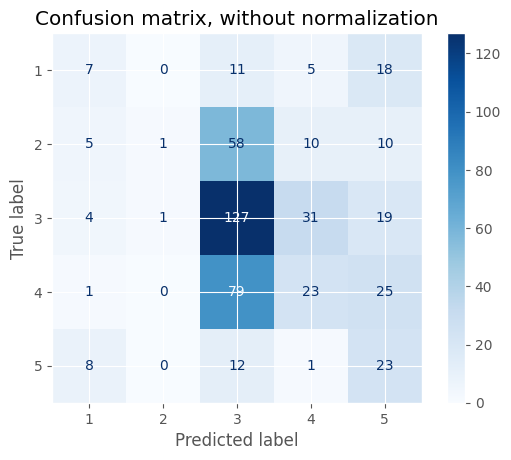

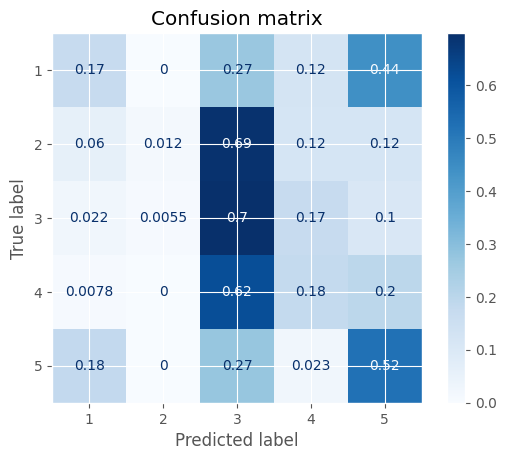

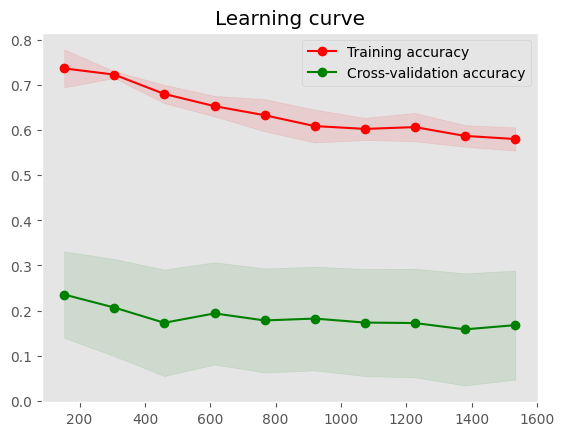

In [93]:
xgboost_tuned_clf = backtest_xgboost(X_train_one, y_train_one, X_test_one, y_test_one, parameters, weights_train_one, weights_test_one)
plot_learning_curve(xgboost_tuned_clf, X_train_one, y_train_one - 1)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Confusion matrix, without normalization
[[74  8  0  0 16]
 [ 6 15  4  6 15]
 [ 9 10  5 20 31]
 [10 10  9 37 50]
 [23 15 11 25 69]]
Normalized confusion matrix
[[0.75510204 0.08163265 0.         0.         0.16326531]
 [0.13043478 0.32608696 0.08695652 0.13043478 0.32608696]
 [0.12       0.13333333 0.06666667 0.26666667 0.41333333]
 [0.0862069  0.0862069  0.07758621 0.31896552 0.43103448]
 [0.16083916 0.1048951  0.07692308 0.17482517 0.48251748]]
###################

Accuracy is 0.4181905678537054
###################

              precision    recall  f1-score   support

           0       0.60      0.76      0.67 64.76923076923082
           1       0.25      0.33      0.29 30.53846153846155
           2       0.17      0.07      0.10 50.153846153846175
           3       0.43      0.32      0.37 78.0769230769232
           4       0.38      0.48      0.43 96.15384615384632

    accuracy                           0.42 319.6

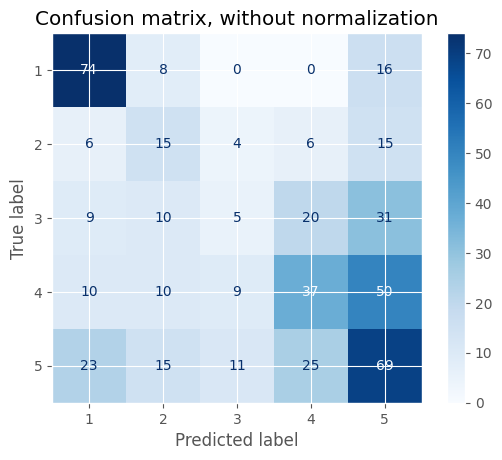

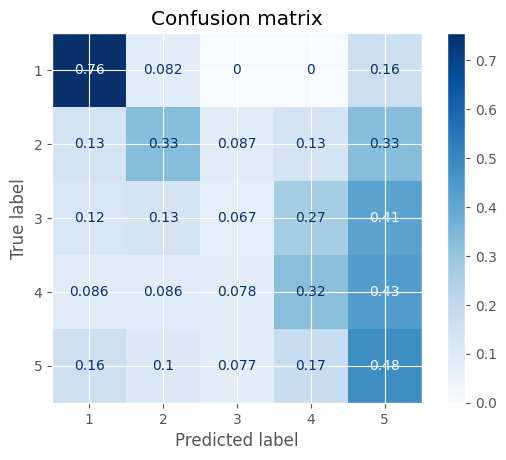

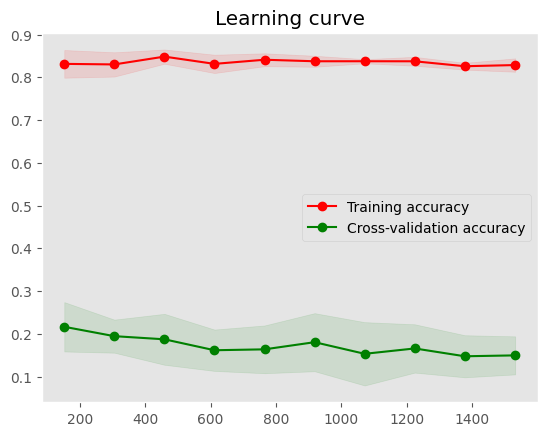

In [94]:
xgboost_tuned_clf = backtest_xgboost(X_train_five, y_train_five, X_test_five, y_test_five, parameters, weights_train_five, weights_test_five)
plot_learning_curve(xgboost_tuned_clf, X_train_five, y_train_five - 1)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Confusion matrix, without normalization
[[ 94   0   0   0  10]
 [ 12   4   1   1  14]
 [ 14   2   2   3  28]
 [  8   3   1   9  47]
 [ 33   1   0  24 166]]
Normalized confusion matrix
[[0.90384615 0.         0.         0.         0.09615385]
 [0.375      0.125      0.03125    0.03125    0.4375    ]
 [0.28571429 0.04081633 0.04081633 0.06122449 0.57142857]
 [0.11764706 0.04411765 0.01470588 0.13235294 0.69117647]
 [0.14732143 0.00446429 0.         0.10714286 0.74107143]]
###################

Accuracy is 0.5788331726133076
###################

              precision    recall  f1-score   support

           0       0.58      0.91      0.71 68.46153846153855
           1       0.40      0.12      0.19 21.307692307692307
           2       0.50      0.04      0.07 32.076923076923094
           3       0.24      0.12      0.16 45.61538461538462
           4       0.63      0.75      0.68 151.61538461538464

    accuracy         

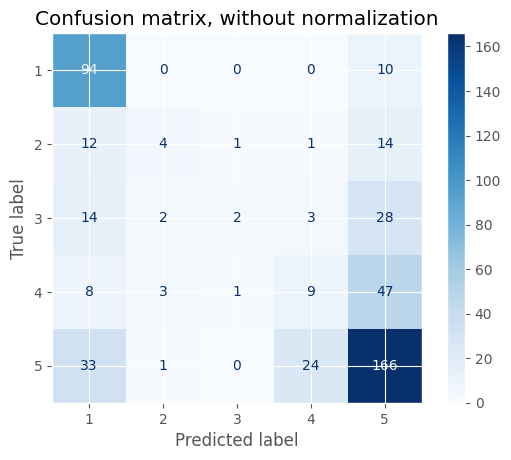

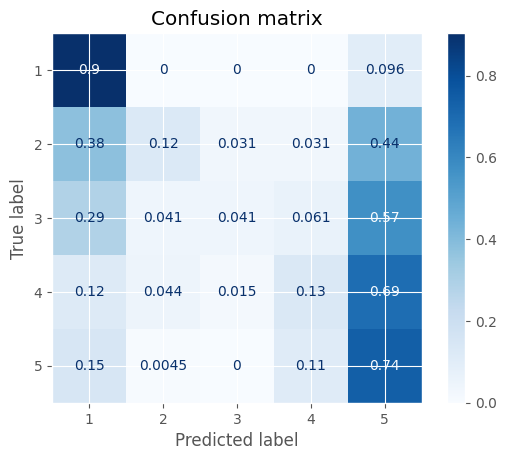

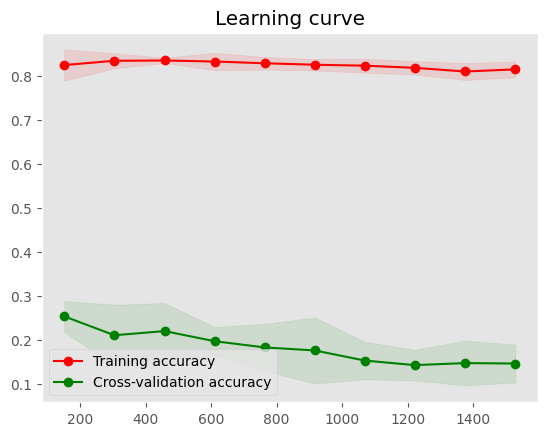

In [96]:
xgboost_tuned_clf = backtest_xgboost(X_train_ten, y_train_ten, X_test_ten, y_test_ten, parameters, weights_train_ten, weights_test_ten)
plot_learning_curve(xgboost_tuned_clf, X_train_ten, y_train_ten - 1)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Confusion matrix, without normalization
[[ 95   0   0   0  12]
 [ 11   0   0   0   8]
 [ 14   0   0   0  10]
 [  6   0   0   0  27]
 [ 40   0   0   0 252]]
Normalized confusion matrix
[[0.88785047 0.         0.         0.         0.11214953]
 [0.57894737 0.         0.         0.         0.42105263]
 [0.58333333 0.         0.         0.         0.41666667]
 [0.18181818 0.         0.         0.         0.81818182]
 [0.1369863  0.         0.         0.         0.8630137 ]]
###################

Accuracy is 0.7318489835430784
###################

              precision    recall  f1-score   support

           0       0.56      0.89      0.69 70.38461538461549
           1       1.00      0.00      0.00 12.692307692307692
           2       1.00      0.00      0.00 15.846153846153841
           3       1.00      0.00      0.00 21.23076923076923
           4       0.82      0.86      0.84 197.69230769230703

    accuracy         

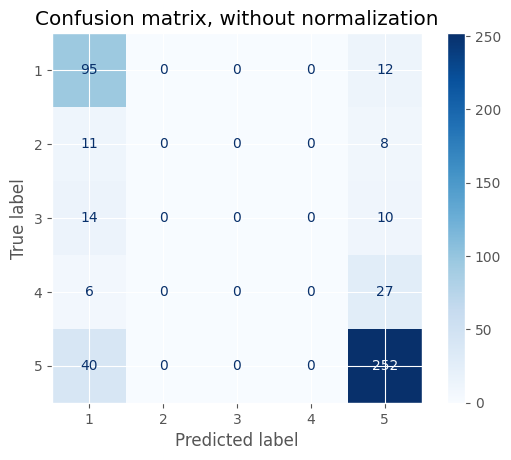

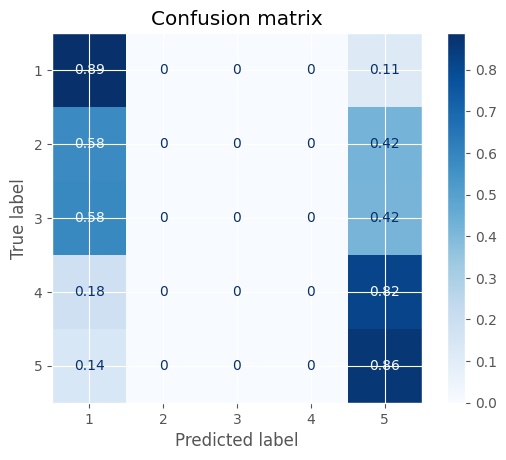

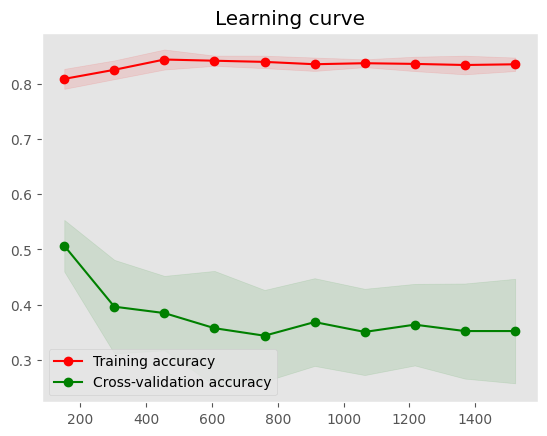

In [97]:
xgboost_tuned_clf = backtest_xgboost(X_train_twenty, y_train_twenty, X_test_twenty, y_test_twenty, parameters, weights_train_twenty, weights_test_twenty)
plot_learning_curve(xgboost_tuned_clf, X_train_twenty, y_train_twenty - 1)